### **Анализ оттока клиентов банка**

Ссылка на презентацию: https://disk.yandex.ru/i/0jSrAyKTGGsMng

Ссылка на дашборд: https://public.tableau.com/authoring/Metanprom_16883266760830/Dashboard1#1

Исследование проводится для менеджера отдела маркетинга банка "Метанпром". 

**Цель исследования:**
- провести анализ оттока клиентов
- выделить сегменты клиентов, подверженных оттоку
- разработать рекомендации для отдела маркетинга по удержанию клиентов

**Описание данных:**
Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `equity`  — количество баллов собственности
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

**Задачи:**
- Загрузить данные и библиотеки, знакомство с данными
- Предобработка данных (поиск пропусков, дублей, выбросов, приведение к нужным типам данных, категоризация и кодирование данных)
- Анализ данных (анализ распределения признаков, портрета клиентов, составление портрета отточного клиента, корреляционный анализ, формирование промежуточных выводов, выделение признаков, влияющих на отток)
- Проверка статистических гипотез (выдвижение и проверка первой гипотезы, выдвижение и проверка второй гипотезы)
- Формирование промежуточных выводов
- Сегментация
- Выводы и рекомендации

### Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_columns', None)
!pip install phik
from phik import phik_matrix
from scipy.stats import shapiro
from scipy import stats as st

In [2]:
# чтение файла bank_scrooge.csv с данными и сохранение его в переменную 
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df = pd.read_csv(path)

In [3]:
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [5]:
df.isna().sum()

USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

In [6]:
for col in df.columns:
    print(f'{col}: {df[col].isna().sum()/df.shape[0]*100:.2f}%')
#определим количество пропусков в процентах

USERID: 0.00%
score: 0.00%
city: 0.00%
gender: 0.00%
age: 0.26%
equity: 0.00%
balance: 22.95%
products: 0.00%
credit_card: 0.00%
last_activity: 0.00%
EST_SALARY: 0.00%
churn: 0.00%


In [7]:
df.duplicated().sum()

0

In [8]:
df['USERID'].duplicated().sum()

73

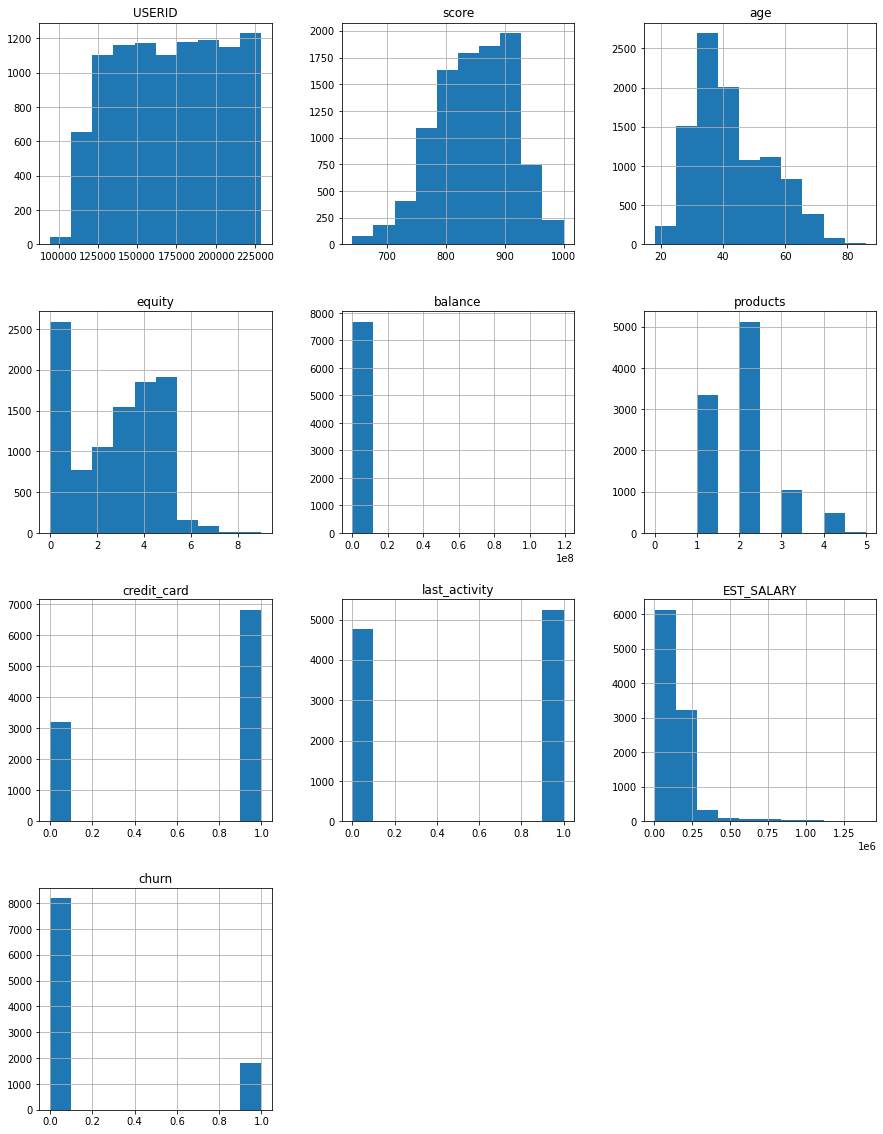

In [9]:
df.hist(figsize=(15,20));

In [10]:
df['balance'].describe()

count    7.705000e+03
mean     8.277943e+05
std      1.980614e+06
min      0.000000e+00
25%      2.955542e+05
50%      5.242722e+05
75%      9.807058e+05
max      1.191136e+08
Name: balance, dtype: float64

In [11]:
df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

Данные по городам соответствуют ТЗ

Необходимо привести название столбцов к типичному написанию, колонку с возрастом и баллами кредитного скоринга перевести в формат int, определить природу пропусков. В столбце с id пользователей имеется 73 дубля, необходимо их удалить, поскольку значения в этом столбце должны быть уникальными и дубли составляют меньше одного процента от общего количества. Больше всего клиентов с 2 продуктами, кредитная карта есть у большинства. Больше всего клиентов в возрасте 30-40 лет

### Предобработка данных

#### Переименование столбцов

In [12]:
# приводим написание названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [13]:
df = df.rename(columns = {'userid': 'user_id'})

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


#### Удаление дублей

Перед удалением посмотрим являются ли данные действительно дублями. Для начала создадим и выведем датафрейм с предполагаемыми дублями

In [15]:
duplicates = df[df['user_id'].duplicated(keep=False)]
duplicates

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0
9785,168998,895.0,Рыбинск,М,44.0,0,282653.53,3,0,0,255296.47,0
9819,140934,832.0,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0
9880,217412,886.0,Ярославль,Ж,35.0,3,1026172.14,2,1,0,53099.16,0


Посмотрим какое количество уникальных значений в каждом столбце нового датафрейма

In [16]:
for column in duplicates.columns:
    if column != 'userid':
        unique_values = duplicates[column].unique()
        print(f"Column: {column}\nUnique Values: {len(unique_values)}\n")

Column: user_id
Unique Values: 73

Column: score
Unique Values: 107

Column: city
Unique Values: 2

Column: gender
Unique Values: 2

Column: age
Unique Values: 44

Column: equity
Unique Values: 8

Column: balance
Unique Values: 98

Column: products
Unique Values: 5

Column: credit_card
Unique Values: 2

Column: last_activity
Unique Values: 2

Column: est_salary
Unique Values: 145

Column: churn
Unique Values: 2



Судя по количеству уникальных значений в столбце с заработной платой, перед нами не дубли. Посмотрим сколько будет дублей, если проверять не только по id клиента, но и по полу и возрасту

In [17]:
df[df[['user_id', 'gender', 'age']].duplicated(keep=False)]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3274,155765,863.0,Ярославль,М,30.0,5,1036114.50,5,1,1,150744.50,1
5197,155765,923.0,Рыбинск,М,30.0,0,NaN,1,1,1,120296.60,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0


Мы видим, что в полученных данных, значения в других столбцах не совпадают. Отмечу, что id совпадают у пользователей из разных городов, можно сделать предположение, что id пользователей из Рыбинска задублировались с id клиентов из Ярославля. Скорее всего user_id уникального для каждого филиала, но не для всей сети. Удалять дубли не будем

#### Кодирование данных

Посмотрим как связаны пропуски с другими признаками. Для этого сначала закодируем столбцы с полом и городом и построим тепловую карту.

In [20]:
df['gender_n'] = df['gender']
df['city_n'] = df['city']
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_n,city_n
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,Ж,Рыбинск
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,Ж,Рыбинск
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,Ж,Рыбинск
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,Ж,Ярославль
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,М,Ярославль


In [21]:
df = pd.get_dummies(df, columns = ['gender_n', 'city_n'])
df = df.rename(
    columns = ({'gender_n_Ж':'female', 'gender_n_М':'male',
        'city_n_Рыбинск':'Рыбинск', 'city_n_Ростов':'Ростов', 'city_n_Ярославль':'Ярославль'})
)
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,female,male,Ростов,Рыбинск,Ярославль
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1


#### Обработка пропусков

In [22]:
age_nul = df.loc[df['age'].isna()]
age_nul

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,female,male,Ростов,Рыбинск,Ярославль
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0,0,1,0,0,1
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0,1,0,0,1,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0,0,1,0,0,1
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1,1,0,1,0,0
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0,0,1,0,1,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0,1,0,0,1,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0,1,0,0,1,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0,1,0,0,1,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0,1,0,0,1,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0,1,0,0,0,1


In [23]:
balance_nul = df.loc[df['balance'].isna()]
balance_nul

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,female,male,Ростов,Рыбинск,Ярославль
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,1,0,0,0,1
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,0,1,1,0,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,0,1,1,0,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Ростов,М,38.0,0,NaN,1,0,0,171763.69,0,0,1,1,0,0
9984,125941,729.0,Ярославль,Ж,42.0,0,NaN,1,1,1,687538.70,0,1,0,0,0,1
9993,219924,884.0,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0,1,0,0,1,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0,0,1,0,0,1


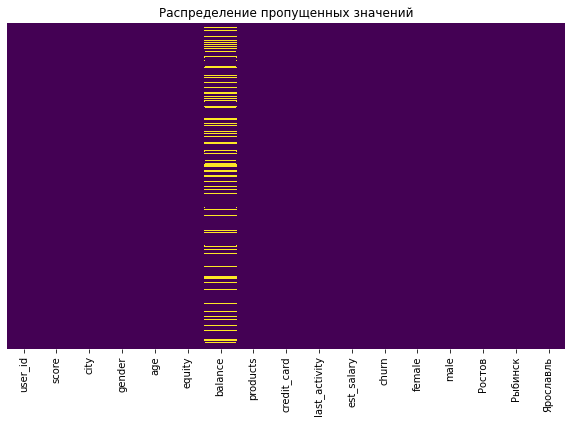

In [24]:
# Создание датафрейма с информацией о пропусках
missing_data = df.isnull()

# Создание тепловой карты для визуализации распределения пропущенных значений
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data, cmap='viridis', cbar=False, yticklabels=False)
plt.title('Распределение пропущенных значений');


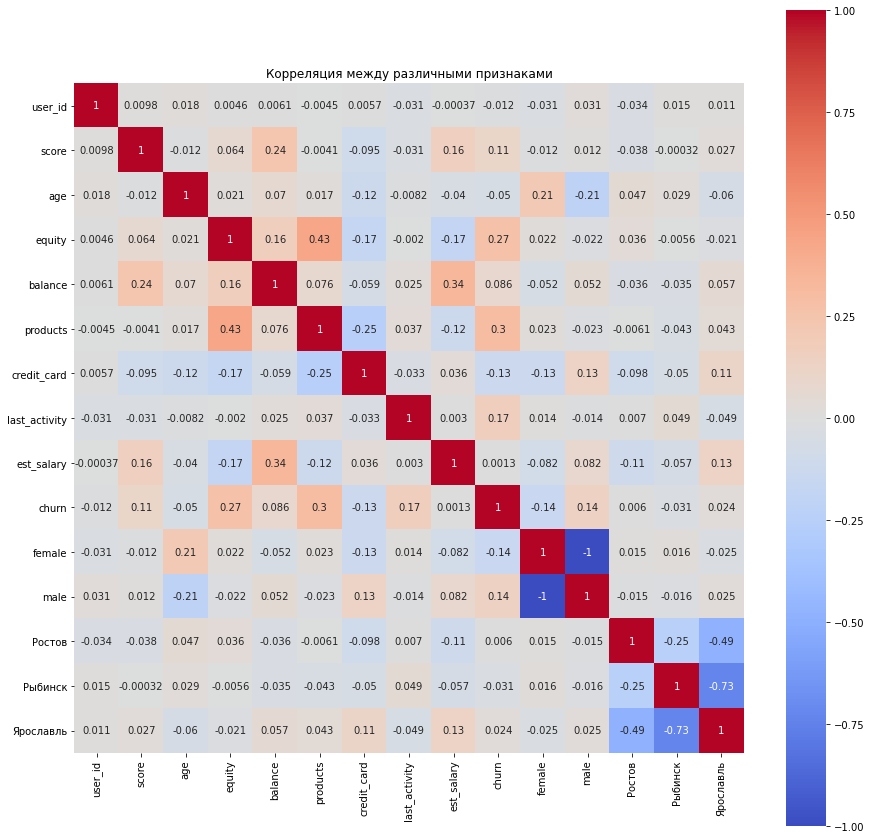

In [25]:
correlation = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='coolwarm', center=0)

plt.title('Корреляция между различными признаками');


Мы видим, что возраст в большей степени коррелирует с полом, а баланс с заработной платой

In [26]:
age_nul.groupby('gender').agg(count=('user_id','count'))

,count
gender,
Ж,12
М,14


In [27]:
age_nul.groupby('churn').agg(count=('user_id','count'))

,count
churn,
0,25
1,1


In [28]:
df.groupby('gender').agg(median=('age', 'median'))

,median
gender,
Ж,43.0
М,38.0


После удаления дублей в столбце с id пользователей, пропусков в столбце возраста осталось всего 4. Пропуски чаще встречаются у клиентов, которые остались. Данные в столбце с возрастом отсутствуют случайно, таким образом пропуски в этом столбце относятся к MCAR. Учитывая разное медианное значение возраста в зависимости от пола, заполним пропуски в этом столбцы медианным значением возраста в зависимости от пола

In [29]:
df['age'] = df['age'].fillna(df.groupby('gender')['age'].transform('median'))

In [30]:
#приведем столбец к нужному типу
df['age'] = df['age'].astype('int64')

In [31]:
df['score'] = df['score'].astype('int64')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  int64  
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
 12  female         10000 non-null  uint8  
 13  male           10000 non-null  uint8  
 14  Ростов         10000 non-null  uint8  
 15  Рыбинск        10000 non-null  uint8  
 16  Ярославль      10000 non-null  uint8  
dtypes: float64(2), int64(8), object(2), uint8(5)
memory

In [33]:
balance_nul.groupby('churn').agg(count=('user_id','count'))

,count
churn,
0,2282
1,13


In [34]:
balance_nul_city = balance_nul.groupby('city').agg(count_nul=('user_id','count'))
balance_nul_city['count'] = df.groupby('city').agg(count=('user_id','count'))
balance_nul_city['percent'] = balance_nul_city['count_nul']/balance_nul_city['count'] *100
balance_nul_city

,count_nul,count,percent
city,,,
Ростов,235,1417,16.584333
Рыбинск,593,2695,22.003711
Ярославль,1467,5888,24.915082


In [35]:
balance_nul_gender = balance_nul.groupby('gender').agg(count_nul=('user_id','count'))
balance_nul_gender['count'] = df.groupby('gender').agg(count=('user_id','count'))
balance_nul_gender['percent'] = balance_nul_gender['count_nul']/balance_nul_gender['count'] *100
balance_nul_gender

,count_nul,count,percent
gender,,,
Ж,1013,4995,20.280280
М,1282,5005,25.614386


In [36]:
balance_nul_equity = balance_nul.groupby('equity').agg(count_nul=('user_id','count'))
balance_nul_equity['count'] = df.groupby('equity').agg(count=('user_id','count'))
balance_nul_equity['percent'] = balance_nul_equity['count_nul']/balance_nul_equity['count'] *100
balance_nul_equity

,count_nul,count,percent
equity,,,
0,2180,2592,84.104938
1,114,774,14.728682
3,1,1543,0.064809


In [37]:
balance_nul.groupby('products').agg(count_nul=('user_id','count'))

,count_nul
products,
0,1
1,1950
2,315
3,29


In [38]:
balance_nul_credit = balance_nul.groupby('credit_card').agg(count_nul=('user_id','count'))
balance_nul_credit['count'] = df.groupby('credit_card').agg(count=('user_id','count'))
balance_nul_credit['percent'] = balance_nul_credit['count_nul']/balance_nul_credit['count'] *100
balance_nul_credit

,count_nul,count,percent
credit_card,,,
0,423,3196,13.235294
1,1872,6804,27.513228


Мы видим что пропуски в столбце баланс чаще встречаются у клиентов из Ярославля, мужчин с количеством баллов собственности 0, одним продуктом и кредитной картой. В связи с этим, нельзя утверждать, что пропуски в этом столбце случайны, поэтому оставим пропуски без заполнения и не будем удалять.

#### Поиск выбросов

In [39]:
df['est_salary'].describe()

count    1.000000e+04
mean     1.478669e+05
std      1.393885e+05
min      2.546300e+03
25%      7.525190e+04
50%      1.196581e+05
75%      1.745005e+05
max      1.395064e+06
Name: est_salary, dtype: float64

Минимальный размер оплаты труда в 2023 г в России составляет 16 242, в 2022 г 15 279, при этом мы видим, что в графе с зарплатой минимальное значение 2546,3. Посмотрим какое количество строк содержит данные о зарплате ниже МРОТ на 2022г(имеющиеся у нас данные скорее всего за прошлый год)

In [40]:
df.loc[df['est_salary']<15279]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,female,male,Ростов,Рыбинск,Ярославль
226,192516,793,Рыбинск,Ж,67,3,339511.05,2,0,0,14781.04,0,1,0,0,1,0
443,207658,875,Ярославль,Ж,76,5,676450.87,3,0,1,11319.50,0,1,0,0,0,1
505,205035,725,Рыбинск,Ж,77,3,73.00,2,0,1,8729.84,0,1,0,0,1,0
558,181465,762,Ростов,М,57,3,323489.00,2,1,0,15164.72,1,0,1,1,0,0
1141,228620,775,Рыбинск,М,25,4,60923.17,2,1,1,13678.54,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9365,171110,788,Рыбинск,Ж,76,2,223228.01,2,0,0,8260.33,0,1,0,0,1,0
9510,169933,784,Ярославль,М,26,2,69345.64,2,1,1,13443.48,0,0,1,0,0,1
9595,183128,799,Ростов,Ж,19,6,17202.68,1,1,0,13550.37,0,1,0,1,0,0
9744,178968,820,Ярославль,М,21,4,26361.03,1,1,1,13459.43,0,0,1,0,0,1


Найдено 63 строки, эти данные похожи на выбросы и составляют небольшой процент от общего количества данных, поэтому удалим их

In [41]:
df = df.loc[df['est_salary']>15279]

Проверим, есть ли в данных клиенты без продуктов

In [42]:
df.loc[df['products'] ==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,female,male,Ростов,Рыбинск,Ярославль
8957,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,1,0,0,1,0


У одного клиента нет продуктов, 0 баланс, нет продуктов и он не активен. Удалим эти данные

In [43]:
df = df.loc[df['products'] !=0]

#### Категоризация данных

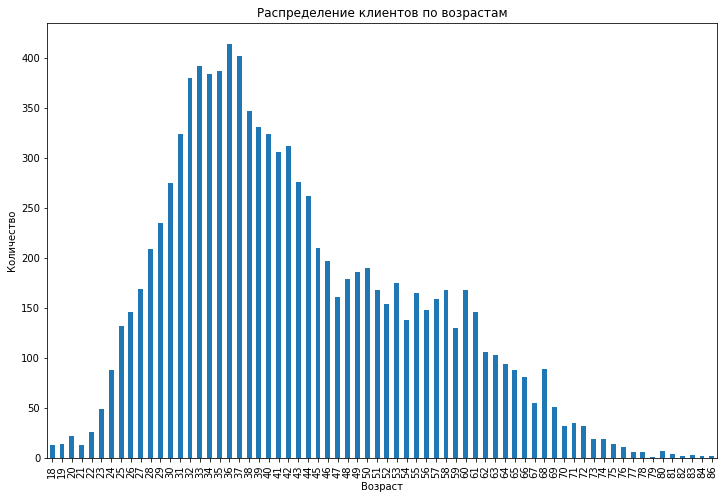

In [44]:
df['age'].value_counts().sort_index().plot(kind='bar', figsize=(12, 8))
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение клиентов по возрастам');

Для категоризации клиентов по возрасту будем использовать модель RBC Royal Bank (https://cyberleninka.ru/article/n/kriterii-i-priznaki-segmentatsii-potrebiteley-bankovskih-uslug/viewer). У нас получаются следующие возрастные группы:
- 18-34 лет
- 35-49 лет
- 50-59 лет
- 60 лет и старше

In [45]:
def age_group(age):
    if 18<=age<35:
        return '18-34'
    if 35<=age<50:
        return '35-49'
    if 50<=age<60:
        return '50-59'
    if 60<=age:
        return '60+'

In [46]:
df['age_group'] = df['age'].apply(age_group)
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,female,male,Ростов,Рыбинск,Ярославль,age_group
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0,18-34
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0,35-49
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,1,0,0,1,0,18-34
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1,50-59
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,1,0,0,1,18-34


In [47]:
df.groupby('age_group').agg({'user_id':'count'})

,user_id
age_group,
18-34,2871
35-49,4294
50-59,1595
60+,1176


Каждая из групп у нас многочисленная (не менее 1168 человек). 

### Анализ данных

#### Анализ распределения признаков

In [49]:
df.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,female,male,Ростов,Рыбинск,Ярославль
count,9936.000000,9936.000000,9936.000000,9936.000000,7.642000e+03,9936.000000,9936.000000,9936.000000,9.936000e+03,9936.000000,9936.000000,9936.000000,9936.00000,9936.000000,9936.000000
mean,171772.654791,848.876812,42.712057,2.624799,8.322437e+05,1.868861,0.680455,0.523450,1.487443e+05,0.182568,0.498490,0.501510,0.14070,0.268720,0.590580
std,33723.892998,65.476986,12.074134,1.982390,1.987976e+06,0.792271,0.466324,0.499475,1.394057e+05,0.386332,0.500023,0.500023,0.34773,0.443316,0.491752
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,1.540806e+04,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,142638.500000,802.000000,33.000000,0.000000,2.982991e+05,1.000000,0.000000,0.000000,7.612654e+04,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,172685.500000,853.000000,40.000000,3.000000,5.273829e+05,2.000000,1.000000,1.000000,1.201435e+05,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000
75%,201255.500000,900.000000,51.000000,4.000000,9.845008e+05,2.000000,1.000000,1.000000,1.749490e+05,0.000000,1.000000,1.000000,0.00000,1.000000,1.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


Баллы кредитного скоринга находятся в пределах 642-1000 баллов с медианным значением 853.

Возраст клиентов от 18 до 86

Количество баллов собственности от 0 до 9, медианное значение 3

Продуктов от 0 до 5 медианное значение 2

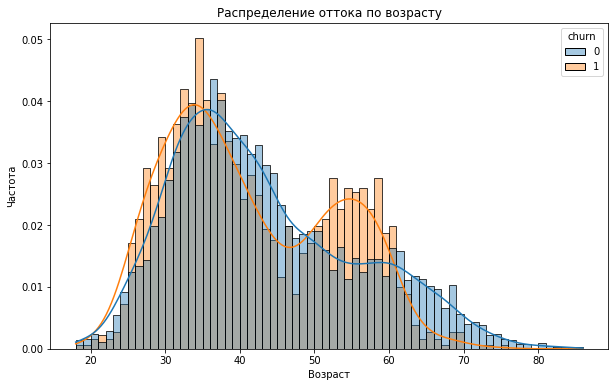

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='churn', stat='density', common_norm=False, alpha = 0.4, kde=True, binwidth=1)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение оттока по возрасту');

По графику видно, что уходят чаще клиенты в возрасте от 25 до 35 лет и с 50 до 60, при этом клиенты в возрасте 35 до 50 и 60+ чаще остаются клиентами. Люди в группе от 25 до 35 лет стремятся повысить уровень жизни, возможно для этой категории были бы интересны партнерские предложения только для клиентов банка и кэшбэк. Клиенты в возрасте от 50-60 лет озабочены вопросом сбережения и накопления денег перед выходом на пенсию, этой категории возможно были бы интересны сберегательные вклады и  инвестиционные программы

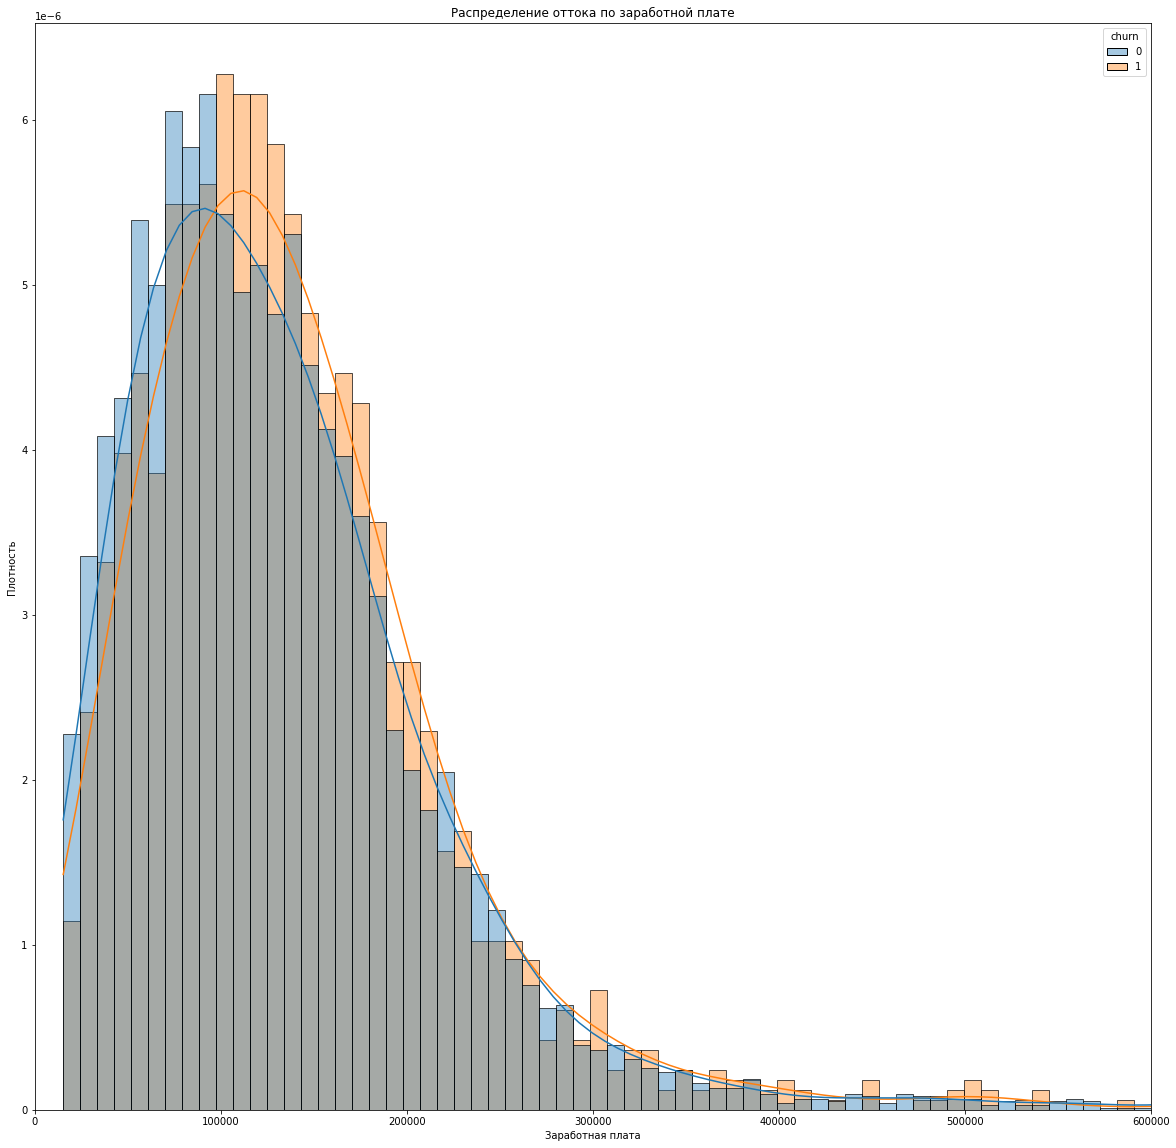

In [51]:
plt.figure(figsize=(20, 20))
sns.histplot(data=df, x='est_salary', hue='churn', stat='density', common_norm=False, alpha = 0.4, kde=True)
plt.xlabel('Заработная плата')
plt.ylabel('Плотность')
plt.title('Распределение оттока по заработной плате')
plt.xlim(0,600000);

По графику клиенты с более высоким доходом чаще уходят, что тоже может говорить о потребности клиентов в инструментах приумножения средств

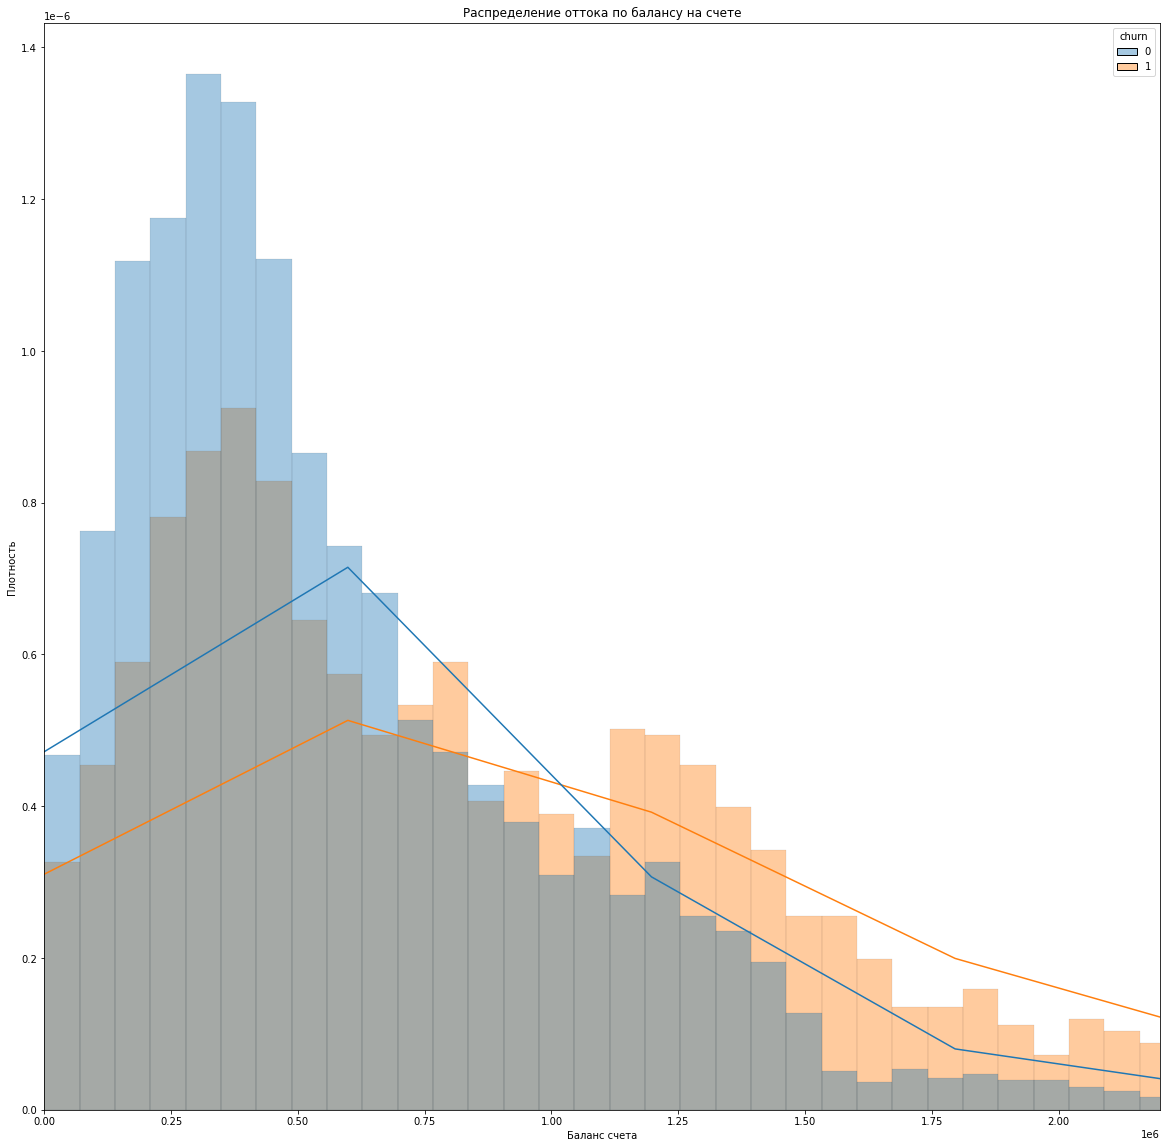

In [52]:
plt.figure(figsize=(20, 20))
sns.histplot(data=df, x='balance', hue='churn', stat='density', common_norm=False, alpha = 0.4, kde=True)
plt.xlabel('Баланс счета')
plt.ylabel('Плотность')
plt.title('Распределение оттока по балансу на счете')
plt.xlim(0,2200000);

Клиенты с большим остатком на счете уходят чаще

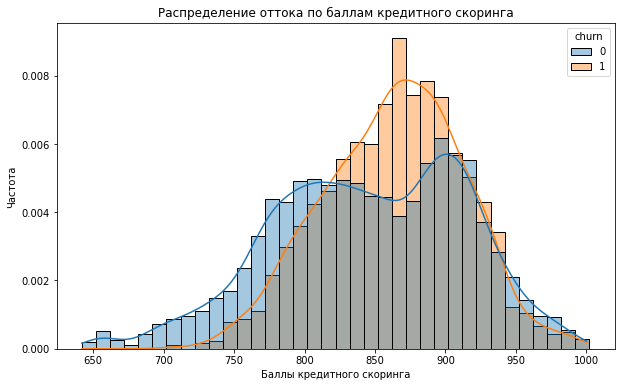

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='score', hue='churn', stat='density', common_norm=False, alpha = 0.4, kde=True, binwidth=10)
plt.xlabel('Баллы кредитного скоринга')
plt.ylabel('Частота')
plt.title('Распределение оттока по баллам кредитного скоринга');

Клиенты с количеством баллов от 820 до 900 уходят чаще

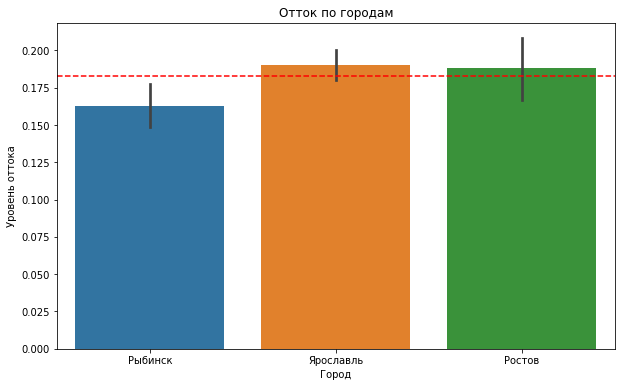

In [55]:
mean_churn = df['churn'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='churn', data=df)
plt.axhline(mean_churn, color='red', linestyle='--')
plt.title('Отток по городам')
plt.xlabel('Город')
plt.ylabel('Уровень оттока');

In [56]:
city_churn = df.groupby('city')['churn'].agg(['sum', 'count'])
city_churn['churn_percent'] = city_churn['sum']/city_churn['count']*100
city_churn

,sum,count,churn_percent
city,,,
Ростов,263,1398,18.812589
Рыбинск,435,2670,16.292135
Ярославль,1116,5868,19.018405


Чаще уходят клиенты из Ярославля и чаще остаются в Рыбинске, возможно это связано с тем, что в Рыбинске заключено большое количество зарплатных договоров

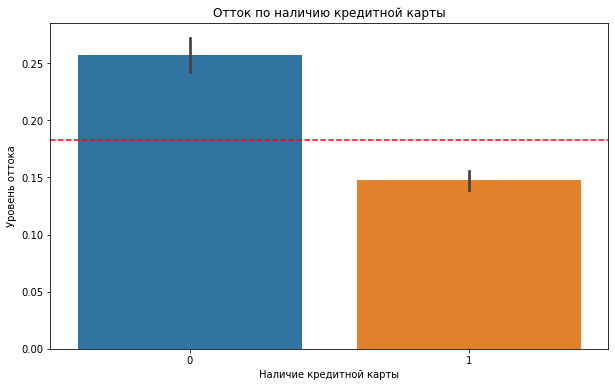

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(x='credit_card', y='churn', data=df)
plt.axhline(mean_churn, color='red', linestyle='--')
plt.title('Отток по наличию кредитной карты')
plt.xlabel('Наличие кредитной карты')
plt.ylabel('Уровень оттока');

Чаще уходят клиенты без кредитной карты

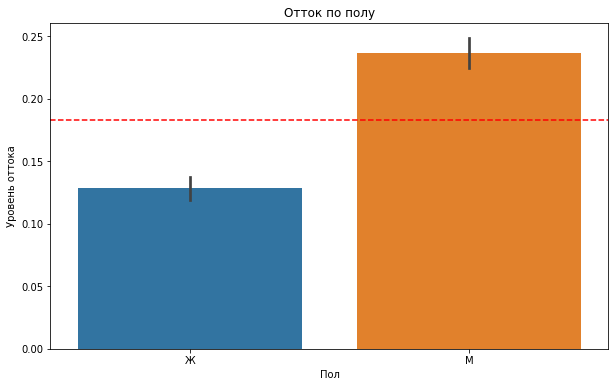

In [60]:
plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='churn', data=df)
plt.axhline(mean_churn, color='red', linestyle='--')
plt.title('Отток по полу')
plt.xlabel('Пол')
plt.ylabel('Уровень оттока');

Чаще перестают быть клиентами банка мужчины

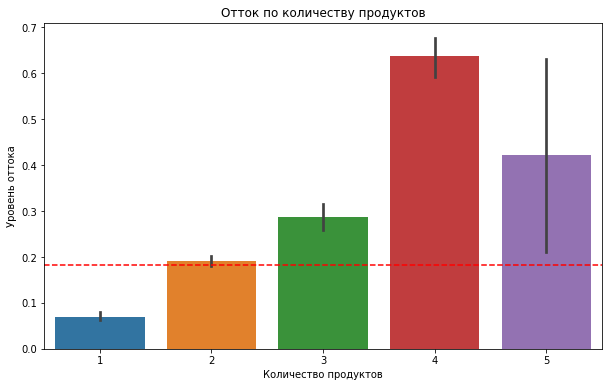

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(x='products', y='churn', data=df)
plt.axhline(mean_churn, color='red', linestyle='--')
plt.title('Отток по количеству продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Уровень оттока');

In [63]:
products_churn = df.groupby('products')['churn'].agg(['sum','count'])
products_churn['percent'] = products_churn['sum']/products_churn['count']*100
products_churn

,sum,count,percent
products,,,
1,234,3328,7.031250
2,976,5091,19.171086
3,296,1028,28.793774
4,300,470,63.829787
5,8,19,42.105263


Чаще остаются клиенты с 1-2 продуктами, а уходят с 3 и выше

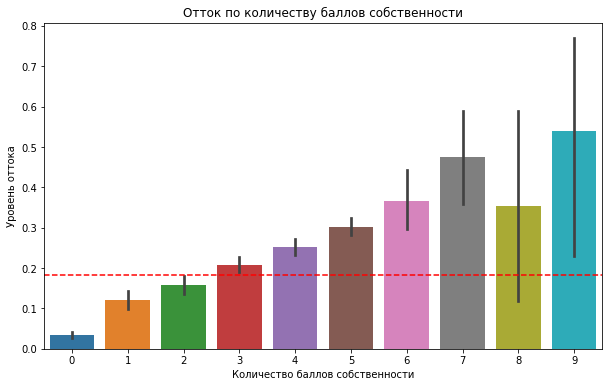

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(x='equity', y='churn', data=df)
plt.axhline(mean_churn, color='red', linestyle='--')
plt.title('Отток по количеству баллов собственности')
plt.xlabel('Количество баллов собственности')
plt.ylabel('Уровень оттока');

Остаются клиенты с баллами собственности 0-2, а уходят с количеством баллов собственности 3 и выше

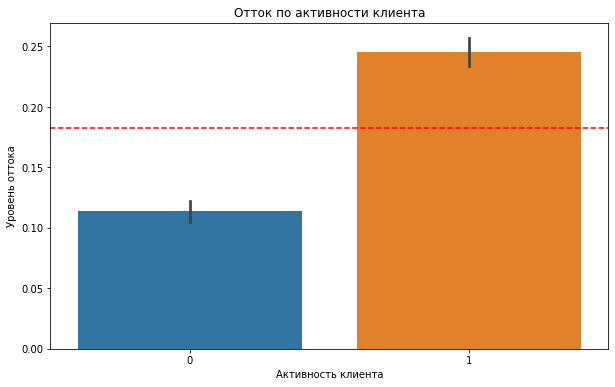

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(x='last_activity', y='churn', data=df)
plt.axhline(mean_churn, color='red', linestyle='--')
plt.title('Отток по активности клиента')
plt.xlabel('Активность клиента')
plt.ylabel('Уровень оттока');

Активные клиенты уходят чаще неактивных

#### Корреляционный анализ

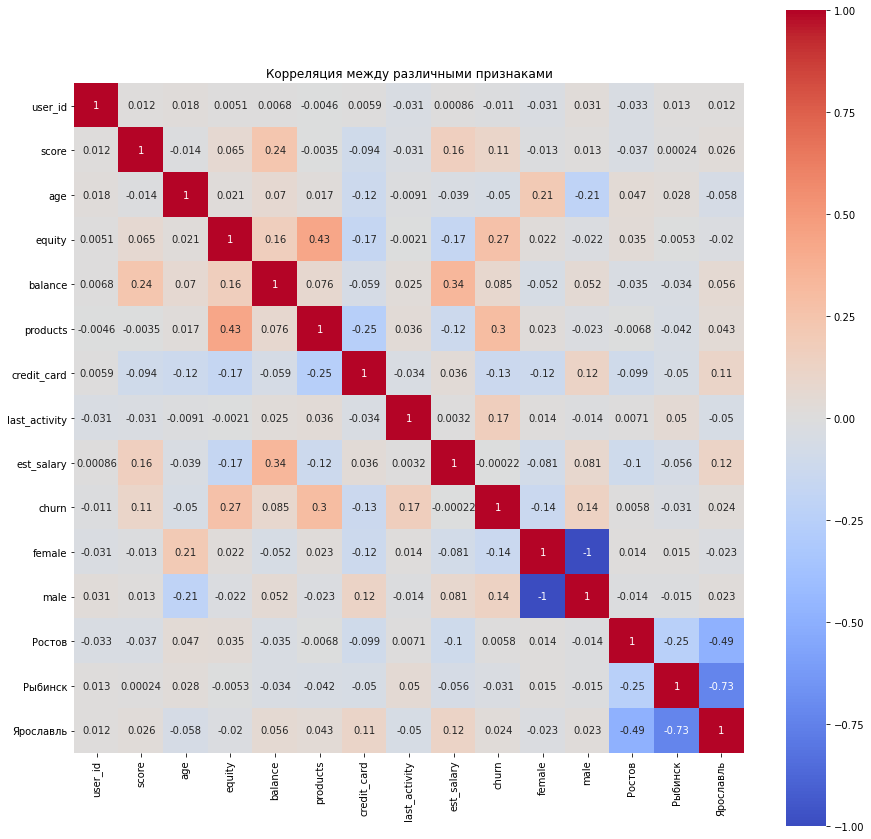

In [68]:
correlation = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='coolwarm', center=0)

plt.title('Корреляция между различными признаками');

баллы кредитного скоринга связаны с балансом на счете, заработной платой и оттоком. Возраст отрицательно связан с наличием кредитной карты. Количество баллов собственности связано с количеством продуктов, оттоком, балансом на счете и отрицательно связана с наличием кредитной карты, заработной платой. Баланс с заработной платой, баллами скоринга и количеством баллов собственности. Количество продуктов с количеством баллов собственности и оттоком, отрицательно связана с наличием кредитной карты и заработной платой. Кредитная карта связана с признаком мужчина. Активность клиента связана с оттоком. Женщины 60+

Дополнительно проведем корреляционный анализ с помощью библиотеки phik, которая позволяет провести анализ нелинейной зависимости

In [69]:

df_without_user_id = df.drop('user_id', axis=1)

correlation_matrix = df_without_user_id.phik_matrix(interval_cols=['score', 'age', 'balance', 'est_salary'])
correlation_matrix

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,female,male,Ростов,Рыбинск,Ярославль,age_group
score,1.000000,0.089081,0.070441,0.044833,0.528861,0.171263,0.420680,0.209489,0.054260,0.393306,0.229168,0.070441,0.070441,0.084874,0.028342,0.081431,0.040967
city,0.089081,1.000000,0.011340,0.090468,0.059849,0.039541,0.125071,0.074786,0.031398,0.170216,0.016519,0.011340,0.011340,1.000000,1.000000,1.000000,0.048250
gender,0.070441,0.011340,1.000000,0.280888,0.062074,0.045413,0.071162,0.193961,0.014523,0.141533,0.217666,1.000000,1.000000,0.014581,0.017031,0.032829,0.316124
age,0.044833,0.090468,0.280888,1.000000,0.043272,0.024605,0.136797,0.153487,0.087019,0.335716,0.182003,0.280888,0.280888,0.067734,0.055276,0.093987,0.939524
equity,0.528861,0.059849,0.062074,0.043272,1.000000,0.000000,0.584202,0.222795,0.051110,0.285641,0.355628,0.062074,0.062074,0.062707,0.000000,0.053007,0.012757
balance,0.171263,0.039541,0.045413,0.024605,0.000000,1.000000,0.000000,0.000000,0.000000,0.374450,0.024474,0.045413,0.045413,0.000000,0.023128,0.047798,0.027564
products,0.420680,0.125071,0.071162,0.136797,0.584202,0.000000,1.000000,0.272130,0.111940,0.224528,0.262075,0.071162,0.071162,0.045117,0.084974,0.108357,0.080742
credit_card,0.209489,0.074786,0.193961,0.153487,0.222795,0.000000,0.272130,1.000000,0.050208,0.037669,0.204930,0.193961,0.193961,0.153409,0.075798,0.178034,0.176885
last_activity,0.054260,0.031398,0.014523,0.087019,0.051110,0.000000,0.111940,0.050208,1.000000,0.052192,0.263482,0.014523,0.014523,0.000000,0.076795,0.076933,0.081483
est_salary,0.393306,0.170216,0.141533,0.335716,0.285641,0.374450,0.224528,0.037669,0.052192,1.000000,0.044263,0.141533,0.141533,0.130271,0.107189,0.176196,0.297549


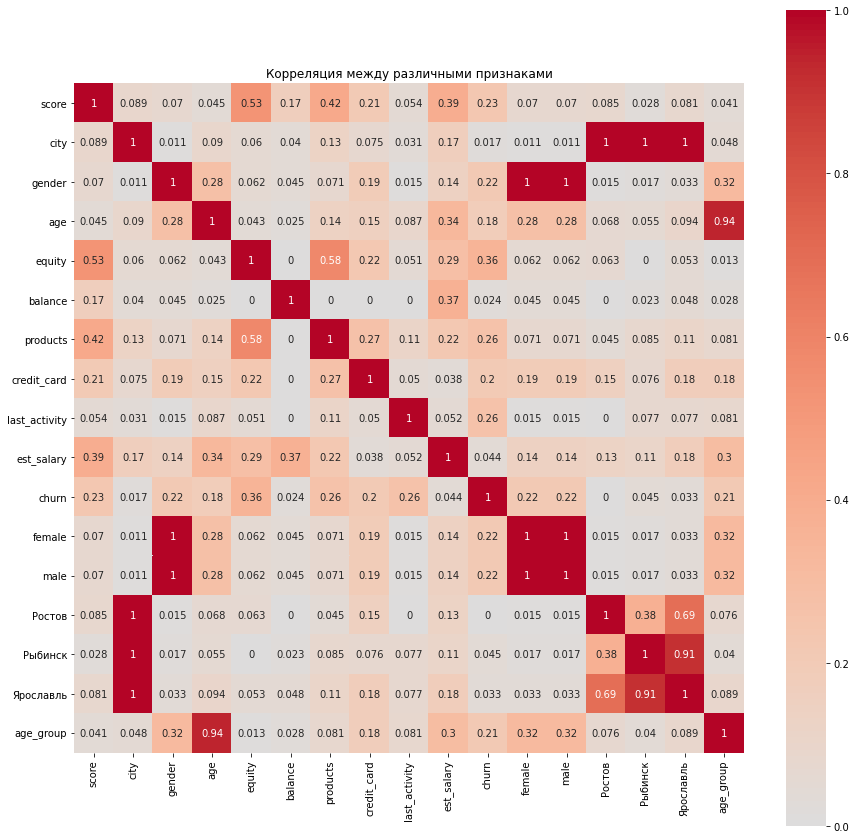

In [70]:
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='coolwarm', center=0)

plt.title('Корреляция между различными признаками');

Баллы кредитного скоринга связаны с количеством баллов собственности, зарплатой, количеством продуктов, оттоком, наличием кредитной карты.
Город связан с количеством продуктов и заработной платой
Пол связан с возрастом(особенно в группе 60+), оттоком, наличием кредитной карты
Возраст связан с заработной платой, полом и оттоком
Количество баллов собственности связано с баллами кредитного скоринга, количеством продуктов, оттоком, заработной платой, наличием кредитной карты
Баланс связан с заработной платой и кредитным скорингом
Активность связана с оттоком и количеством продуктов

По анализу коррелиций можно сказать, что показатели оттока клиентов больше всего у таких параметров:
- количество продуктов 
- количество баллов собственности 
- активность клиента 
- баллы кредитного скоринга 
- пол 
- наличие кредитной карты 

In [71]:
correlation_matrix['churn']

score            0.229168
city             0.016519
gender           0.217666
age              0.182003
equity           0.355628
balance          0.024474
products         0.262075
credit_card      0.204930
last_activity    0.263482
est_salary       0.044263
churn            1.000000
female           0.217666
male             0.217666
Ростов           0.000000
Рыбинск          0.045288
Ярославль        0.033222
age_group        0.211056
Name: churn, dtype: float64

По шкале Чеддока только у количества баллов собственности умеренная связь с оттоком, у остальных признаков она слабая

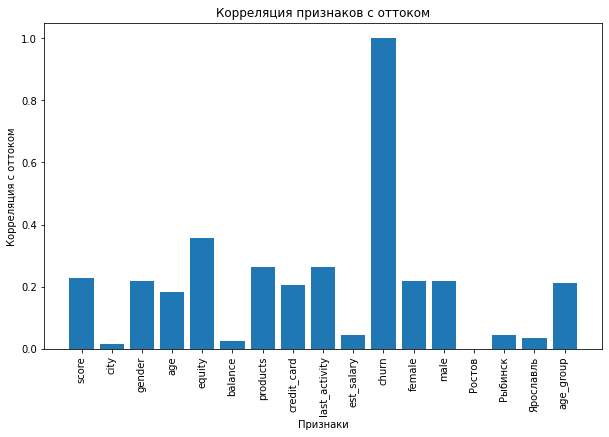

In [72]:
feature_names = correlation_matrix.columns.tolist()
cor_churn_values = correlation_matrix['churn'].tolist()

plt.figure(figsize=(10,6))
plt.bar(feature_names, cor_churn_values)
plt.xlabel('Признаки')
plt.ylabel('Корреляция с оттоком')
plt.title('Корреляция признаков с оттоком')
plt.xticks(rotation=90);

#### Портрет клиента

In [73]:
table = pd.DataFrame(columns=['Признак', 'Отток', 'Не отток', 'Относительная разница'])

# Расчет среднего значения для признаков
mean_salary_churn = df[df['churn'] == 1]['est_salary'].mean()
mean_salary_no_churn = df[df['churn'] == 0]['est_salary'].mean()
mean_age_churn = df[df['churn'] == 1]['age'].mean()
mean_age_no_churn = df[df['churn'] == 0]['age'].mean()
mean_score_churn = df[df['churn'] == 1]['score'].mean()
mean_score_no_churn = df[df['churn'] == 0]['score'].mean()
mean_balance_churn = df[df['churn'] == 1]['balance'].mean()
mean_balance_no_churn = df[df['churn'] == 0]['balance'].mean()

# Расчет медианы для признаков
median_products_churn = df[df['churn'] == 1]['products'].median()
median_products_no_churn = df[df['churn'] == 0]['products'].median()
median_equity_churn = df[df['churn'] == 1]['equity'].median()
median_equity_no_churn = df[df['churn'] == 0]['equity'].median()
median_balance_churn = df[df['churn'] == 1]['balance'].median()
median_balance_no_churn = df[df['churn'] == 0]['balance'].median()
median_salary_churn = df[df['churn'] == 1]['est_salary'].median()
median_salary_no_churn = df[df['churn'] == 0]['est_salary'].median()
median_score_churn = df[df['churn'] == 1]['score'].median()
median_score_no_churn = df[df['churn'] == 0]['score'].median()

# Расчет моды для признаков
mode_city_churn = df[df['churn'] == 1]['city'].mode().values[0]
mode_city_no_churn = df[df['churn'] == 0]['city'].mode().values[0]
mode_gender_churn = df[df['churn'] == 1]['gender'].mode().values[0]
mode_gender_no_churn = df[df['churn'] == 0]['gender'].mode().values[0]
mode_credit_churn = df[df['churn'] == 1]['credit_card'].mode().values[0]
mode_credit_no_churn = df[df['churn'] == 0]['credit_card'].mode().values[0]
mode_activ_churn = df[df['churn'] == 1]['last_activity'].mode().values[0]
mode_activ_no_churn = df[df['churn'] == 0]['last_activity'].mode().values[0]


# Расчет относительной разницы
relative_diff_salary = (mean_salary_churn - mean_salary_no_churn) / mean_salary_no_churn*100
relative_diff_age = (mean_age_churn - mean_age_no_churn) / mean_age_no_churn*100
relative_diff_score = (mean_score_churn - mean_score_no_churn) / mean_score_no_churn*100
relative_diff_balance = (mean_balance_churn - mean_balance_no_churn) / mean_balance_no_churn*100


# Добавление данных в таблицу
table.loc[0] = ['Средняя зарплата', mean_salary_churn, mean_salary_no_churn, relative_diff_salary]
table.loc[1] = ['Средний возраст', mean_age_churn, mean_age_no_churn, relative_diff_age]
table.loc[2] = ['Средний балл кредитного скоринга', mean_score_churn, mean_score_no_churn, relative_diff_score]
table.loc[3] = ['Средний баланс на счете', mean_balance_churn, mean_balance_no_churn, relative_diff_balance]
table.loc[4] = ['Медианное количество продуктов', median_products_churn, median_products_no_churn, '']
table.loc[5] = ['Медианное количество баллов собственности', median_equity_churn, median_equity_no_churn, '']
table.loc[6] = ['Мода города', mode_city_churn, mode_city_no_churn, '']
table.loc[7] = ['Мода пола', mode_gender_churn, mode_gender_no_churn, '']
table.loc[8] = ['Мода наличия кредитной карты', mode_credit_churn, mode_credit_no_churn, '']
table.loc[9] = ['Мода активности клиента', mode_activ_churn, mode_activ_no_churn, '']
table.loc[10] = ['Медианный баланс на счете', median_balance_churn, median_balance_no_churn, '']
table.loc[11] = ['Медианное значение заработной платы', median_salary_churn, median_salary_no_churn, '']
table.loc[12] = ['Медианное значение кредитного скоринга', median_score_churn, median_score_no_churn, '']

In [74]:
table

,Признак,Отток,Не отток,Относительная разница
0,Средняя зарплата,148680.699476,148758.504226,-0.052303
1,Средний возраст,41.435502,42.997168,-3.632022
2,Средний балл кредитного скоринга,863.49118,845.61278,2.114254
3,Средний баланс на счете,1135936.406509,738535.840236,53.809246
4,Медианное количество продуктов,2.0,2.0,
5,Медианное количество баллов собственности,4.0,3.0,
6,Мода города,Ярославль,Ярославль,
7,Мода пола,М,Ж,
8,Мода наличия кредитной карты,1,1,
9,Мода активности клиента,1,0,


Клиент склонный к оттоку: 
- мужчина 
- в возрасте от 25 до 35 лет и с 50 до 60 лет 
- из Ярославля
- без кредитной карты
- с 3 и больше продуктами
- количество баллов собственности 4 и выше
- активный клиент

Клиент склонный остаться: 
- женщина
- в возрасте с 35 до 50 и 60+
- из Рыбинска
- с кредитной картой
- с 1-2 продуктами
- количество баллов собственности 0-2
- неактивный клиент


### Проверка статистических гипотез

ЦПТ говорит о том, что если в выборке достаточно наблюдений, выборочное среднее нормально распределено вокруг среднего генеральной совокупности. И таким образом учитывая наши объемы данных, можно использовать ttest. 

Проверим следующую гипотезу:

**Н0**: доходы оставшихся и отточных клиентов равны

**Н1**: доходы оставшихся и отточных клиентов не равны

In [76]:
df_churn = df.query('churn == 1')
df_no_churn = df.query('churn == 0')

In [78]:
results = st.ttest_ind (
    df_no_churn['est_salary'],
    df_churn['est_salary'], equal_var = False)

alpha = 0.05

print (results.pvalue) 

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print ('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

0.9811447981630032
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Нулевую гипотезу отвергнуть не удалось. Доход в разных группах одинаковый

Проверим гипотезу о различии возраста у оставшихся и отточных клиентов

**Н0**: возраст у оставшихся и отточных клиентов равен

**Н1**: возраст у оставшихся и отточных клиентов не равен

In [80]:
results = st.ttest_ind (
    df_no_churn['age'],
    df_churn['age'], equal_var = False)

alpha = 0.05

print (results.pvalue) 

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print ('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

1.234070954794704e-07
Отвергаем нулевую гипотезу: разница статистически значима


Гипотеза о различии возраста у оставшихся и отточных клиентов подтвердилась

### Формирование промежуточных выводов

Была проведена предобработка данных, после удаления дублей для анализа имеются данные о 9864 клиентах. Пропуски в столбце с балансом оставили без заполнения, т.к. нельзя утверждать, что пропуски в этом столбце случайны.

При анализе данных выявлено, что уходят чаще клиенты в возрасте от 25 до 35 лет и с 50 до 60, при этом клиенты в возрасте от 35 до 50 и 60+ чаще остаются клиентами. Люди в группе от 25 до 35 лет стремятся повысить уровень жизни, возможно для этой категории были бы интересны партнерские предложения только для клиентов банка и кэшбэк. Клиенты в возрасте от 50-60 лет озабочены вопросом сбережения и накопления денег перед выходом на пенсию, этой категории возможно были бы интересны сберегательные вклады и инвестиционные программы. Так же чаще уходят клиенты с более высоким доходом, что тоже может говорить о потребности клиентов в инструментах приумножения средств. В Ярославля самый высокий процент оттока клиентов, самый низкий в Рыбинске, возможно это связано с тем, что в Рыбинске заключено большое количество зарплатных договоров. Чаще уходят активные клиенты без кредитной карты, мужчины с 3 продуктами и выше, с количеством баллов собственности 3 и выше

По анализу коррелиций можно сказать, что показатели оттока клиентов больше всего у таких параметров:
-	количество продуктов
-	количество баллов собственности
-	активность клиента
-	баллы кредитного скоринга
-	пол
-	наличие кредитной карты


Клиент склонный к оттоку:

- мужчина
- в возрасте от 25 до 35 лет и с 50 до 60 лет
- из Ярославля
- без кредитной карты
- с 3 и больше продуктами
- количество баллов собственности 4 и выше
- активный клиент

Клиент склонный остаться:

- женщина
- в возрасте с 35 до 50 и 60+
- из Рыбинска
- с кредитной картой
- с 1-2 продуктами
- количество баллов собственности 0-2
- неактивный клиент

Гипотеза о различии дохода не подтвердилась, доходы в группах одинаковые. Гипотеза о различии возраста в группах оставшихся и отточных клиентов подтвердились

### Сегментация

Сегментацию будем проводить по следующим признакам:

- пол (мужской/женский)
- возраст (25-35/ 35-50/ 50-60/60+)
- наличие кредитной карты (да/нет)
- количество продуктов (1-2/больше 3)
- количество баллов собственности  (0-3, 4 и больше)
- активность клиента (да/нет)
- баллы кредитного скоринга (< 800/>800)

Рассчитаем общебанковский процент оттока клиентов

In [82]:
(df_churn['user_id'].count()/df['user_id'].count()*100).round(2)

18.26

**Сегмент №1**

- пол: мужчина
- возраст:от 50 до 60 лет


In [83]:
#рассчитаем общее количество клиентов из этого сегмента
print('Общее количество клиентов из сегмента №1:', df.query(
'gender== "М" and age>=50 and age<=60' \
      )['user_id'].count())
#рассчитаем число ушедших клиентов из этого сегмента
print('Общее количество отточных клиентов из сегмента №1:', df.query(
'gender== "М" and age>=50 and age<=60 and churn==1'\
      )['user_id'].count())
#рассчитаем долю отточных пользователей
print('Доля отточных пользователей в сегменте№1:', (df.query(
'gender== "М" and age>=50 and age<=60 and churn==1'\
      )['user_id'].count()/df.query(
'gender== "М" and age>=50 and age<=60'\
      )['user_id'].count() *100).round(2))

Общее количество клиентов из сегмента №1: 775
Общее количество отточных клиентов из сегмента №1: 257
Доля отточных пользователей в сегменте№1: 33.16


**Сегмент №2**

- пол: мужчина
- количество продуктов: 3 и больше
- баллы кредитного скоринга: больше 800

In [85]:
#рассчитаем общее количество клиентов из этого сегмента
print('Общее количество клиентов из сегмента №3:', df.query(
'gender== "М" and products >= 3\
and score>=800')['user_id'].count())
#рассчитаем число ушедших клиентов из этого сегмента
print('Общее количество отточных клиентов из сегмента №3:', df.query(
'gender== "М" and products >= 3 and churn==1\
      and score>=800')['user_id'].count())
#рассчитаем долю отточных пользователей
print('Доля отточных пользователей в сегменте№3:', (df.query(
'gender== "М" and products >= 3 and churn==1\
      and score>=800')['user_id'].count()/df.query(
'gender== "М" and products >= 3 \
      and score>=800')['user_id'].count() *100).round(2))

Общее количество клиентов из сегмента №3: 598
Общее количество отточных клиентов из сегмента №3: 326
Доля отточных пользователей в сегменте№3: 54.52


**Сегмент №3**

- наличие кредитной карты: нет
- количество продуктов: 3 и больше


In [87]:
#рассчитаем общее количество клиентов из этого сегмента
print('Общее количество клиентов из сегмента №5:', df.query(
'credit_card==0 and products >= 3')['user_id'].count())
#рассчитаем число ушедших клиентов из этого сегмента
print('Общее количество отточных клиентов из сегмента №5:', df.query(
'credit_card==0 and products >= 3 and churn==1')['user_id'].count())
#рассчитаем долю отточных пользователей
print('Доля отточных пользователей в сегменте№5:', (df.query(
'credit_card==0 and products >= 3 and churn==1')['user_id'].count()/df.query(
'credit_card==0 and products >= 3')['user_id'].count() *100).round(2))

Общее количество клиентов из сегмента №5: 816
Общее количество отточных клиентов из сегмента №5: 265
Доля отточных пользователей в сегменте№5: 32.48


**Сегмент №4**

- количество продуктов: 3 и больше
- количество баллов собственности: 4 и больше
- баллы кредитного скоринга: 800 и больше

In [90]:
#рассчитаем общее количество клиентов из этого сегмента
print('Общее количество клиентов из сегмента №8:', df.query(
'products >= 3 and equity >=4 and score>=800')['user_id'].count())
#рассчитаем число ушедших клиентов из этого сегмента
print('Общее количество отточных клиентов из сегмента №8:', df.query(
'products >= 3 and equity >=4 and score>=800 and churn==1 ')['user_id'].count())
#рассчитаем долю отточных пользователей
print('Доля отточных пользователей в сегменте№8:', (df.query(
'products >= 3 and equity >=4 and score>=800 and churn==1 ')['user_id'].count()/df.query(
'products >= 3 and equity >=4 and score>=800')['user_id'].count() *100).round(2))

Общее количество клиентов из сегмента №8: 821
Общее количество отточных клиентов из сегмента №8: 392
Доля отточных пользователей в сегменте№8: 47.75


**Сегмент №5**

- пол: мужчина
- количество баллов собственности: 4 и больше
- активность клиента: да


In [93]:
#рассчитаем общее количество клиентов из этого сегмента
print('Общее количество клиентов из сегмента №12:', df.query(
'gender== "М" and equity >=4 and last_activity==1')['user_id'].count())
#рассчитаем число ушедших клиентов из этого сегмента
print('Общее количество отточных клиентов из сегмента №12:', df.query(
'gender== "М" and equity >=4 and last_activity==1 and churn==1 ')['user_id'].count())
#рассчитаем долю отточных пользователей
print('Доля отточных пользователей в сегменте№12:', (df.query(
'gender== "М" and equity >=4 and last_activity==1 and churn==1 ')['user_id'].count()/df.query(
'gender== "М" and equity >=4 and last_activity==1')['user_id'].count() *100).round(2))

Общее количество клиентов из сегмента №12: 1046
Общее количество отточных клиентов из сегмента №12: 519
Доля отточных пользователей в сегменте№12: 49.62


#### Приоритизация сегментов

Выберем 3 сегмента с наибольшим процентом отточных клиентов и количеством клиентов в сегменте. Расположим их в порядке убывания приоритетности:

1. **Сегмент №5**

- пол: мужчина
- количество баллов собственности: 4 и больше
- активность клиента: да

2. **Сегмент №4**

- количество продуктов: 3 и больше
- количество баллов собственности: 4 и больше
- баллы кредитного скоринга: 800 и больше

3. **Сегмент №2**

- пол: мужчина
- количество продуктов: 3 и больше
- баллы кредитного скоринга: больше 800



### Выводы и рекомендации

Проведенный анализ показал, что у ряда признаков есть устойчивая корреляция с оттоком клиентов из банка:

-	количество продуктов
-	количество баллов собственности
-	активность клиента
-	баллы кредитного скоринга
-	пол
-	наличие кредитной карты

Были составлены портреты отточного и остающегося клиентов.

Клиент склонный к оттоку:

- мужчина
- в возрасте от 25 до 35 лет и с 50 до 60 лет
- из Ярославля
- без кредитной карты
- с 3 и больше продуктами
- количество баллов собственности 4 и выше
- активный клиент

Клиент склонный остаться:

- женщина
- в возрасте с 35 до 50 и 60+
- из Рыбинска
- с кредитной картой
- с 1-2 продуктами
- количество баллов собственности 0-2
- неактивный клиент


А так же выделены 3 наиболее перспективных для дальнейшей работы сегмента клиентов:

**Сегмент №5**
- пол: мужчина
- количество баллов собственности: 4 и больше
- активность клиента: да

Рекомендации:
- Предложить клиентам продукты по страхованию жилья и автомобилей
- Информирование о новых доступных банковских продуктах
- Карты с кэшбэком, направленные в большей степени на интересы мужчин (автозаправки, товары для спорта и активного отдыха, рыбалки, строймагазины, барбершопы, магазины мужской одежды)
- Разработать партнерские программы с автосалонами (при покупке новой машины, а так же техобслуживании в официальных автосервисах)
- Предложение по вкладам и инвестиционным программам

**Сегмент №4**
- количество продуктов: 3 и больше
- количество баллов собственности: 4 и больше
- баллы кредитного скоринга: 800 и больше

Рекомендации:
- Предложить клиентам продукты по страхованию жилья и автомобилей
- Информирование о новых доступных банковских продуктах
- Предложение по вкладам и инвестиционным программам
- Предложить льготные условия для перевода зарплатной карты в наш банк

**Сегмент №2**

-    пол: мужчина
- количество продуктов: 3 и больше
- баллы кредитного скоринга: больше 800

Рекомендации:
- Предложить клиентам продукты по страхованию жилья и автомобилей
- Предложения по получению кредитной карты 
- Информирование о новых доступных банковских продуктах
- Карты с кэшбэком, направленные в большей степени на интересы мужчин (автозаправки, товары для спорта и активного отдыха, рыбалки, строймагазины, барбершопы, магазины мужской одежды)
- Разработать партнерские программы с автосалонами (при покупке новой машины, а так же техобслуживании в официальных автосервисах)
- Предложения по вкладам и инвестиционным программам